In [1]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

In [2]:
from mario2 import MyMarioEnvironment2

In [3]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [4]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

In [19]:
class GridVanillaDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.90
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=3000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      obs,aud = self.env.reset()
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.001)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False, max_ep=10):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))
      
      self.test_max_episodes = max_ep
      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          # self.env.render(mode="human", save=True, step=steps)

          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
      next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + max(next_q_value_list[index]) * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list, dtype=torch.float).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size)
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [7]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
a = GridVanillaDQN(env)
a.learn()

  4%|▍         | 101/2500 [00:13<05:17,  7.55episodes/s]

Buffer_size: 2960|Train_time:0.004011061191558838| Sub_t:0.004387373924255371
[Episode: 100] - Steps: 29.6 | Rewards: -5.42 | Epsilon: 0.8317637711026726 | loss: 0.871


  8%|▊         | 201/2500 [00:26<04:31,  8.47episodes/s]

Buffer_size: 3000|Train_time:0.003911552429199219| Sub_t:0.004317278861999512
[Episode: 200] - Steps: 28.97 | Rewards: -2.42 | Epsilon: 0.691830970918939 | loss: 2.770


 12%|█▏        | 301/2500 [00:39<04:50,  7.57episodes/s]

Buffer_size: 3000|Train_time:0.0042899250984191895| Sub_t:0.004741282463073731
[Episode: 300] - Steps: 26.19 | Rewards: 2.76 | Epsilon: 0.5754399373371608 | loss: 8.996


 16%|█▌        | 401/2500 [00:50<03:50,  9.11episodes/s]

Buffer_size: 3000|Train_time:0.0038436627388000488| Sub_t:0.004253537654876709
[Episode: 400] - Steps: 25.88 | Rewards: 3.93 | Epsilon: 0.47863009232264275 | loss: 2.353


 20%|██        | 502/2500 [01:00<02:39, 12.51episodes/s]

Buffer_size: 3000|Train_time:0.003772451877593994| Sub_t:0.004207906723022461
[Episode: 500] - Steps: 21.69 | Rewards: 8.55 | Epsilon: 0.3981071705535017 | loss: 4.008


 24%|██▍       | 601/2500 [01:11<04:17,  7.37episodes/s]

Buffer_size: 3000|Train_time:0.003963818550109863| Sub_t:0.004411070346832275
[Episode: 600] - Steps: 24.02 | Rewards: 5.78 | Epsilon: 0.3311311214825956 | loss: 8.580


 28%|██▊       | 701/2500 [01:22<03:04,  9.76episodes/s]

Buffer_size: 3000|Train_time:0.00383162260055542| Sub_t:0.004296426773071289
[Episode: 700] - Steps: 22.26 | Rewards: 8.27 | Epsilon: 0.27542287033382085 | loss: 6.178


 32%|███▏      | 800/2500 [01:33<02:43, 10.42episodes/s]

Buffer_size: 3000|Train_time:0.0037384700775146486| Sub_t:0.004207608699798584
[Episode: 800] - Steps: 23.86 | Rewards: 6.68 | Epsilon: 0.22908676527678132 | loss: 5.044


 36%|███▌      | 901/2500 [01:40<01:43, 15.38episodes/s]

Buffer_size: 3000|Train_time:0.003799436092376709| Sub_t:0.004251549243927002
[Episode: 900] - Steps: 16.28 | Rewards: 12.54 | Epsilon: 0.19054607179632832 | loss: 2.269


 40%|████      | 1001/2500 [01:48<02:14, 11.11episodes/s]

Buffer_size: 3000|Train_time:0.003726673126220703| Sub_t:0.00418853759765625
[Episode: 1000] - Steps: 17.67 | Rewards: 9.61 | Epsilon: 0.15848931924611465 | loss: 4.138


 44%|████▍     | 1102/2500 [01:55<01:18, 17.85episodes/s]

Buffer_size: 3000|Train_time:0.004705605506896973| Sub_t:0.005290853977203369
[Episode: 1100] - Steps: 16.67 | Rewards: 10.82 | Epsilon: 0.13182567385564378 | loss: 4.581


 48%|████▊     | 1204/2500 [02:01<01:11, 18.24episodes/s]

Buffer_size: 3000|Train_time:0.003785991668701172| Sub_t:0.004307537078857422
[Episode: 1200] - Steps: 12.74 | Rewards: 13.38 | Epsilon: 0.10964781961432139 | loss: 2.788


 52%|█████▏    | 1304/2500 [02:07<01:09, 17.21episodes/s]

Buffer_size: 3000|Train_time:0.004545838832855225| Sub_t:0.005180881023406982
[Episode: 1300] - Steps: 12.22 | Rewards: 12.96 | Epsilon: 0.09120108393559365 | loss: 6.907


 56%|█████▌    | 1400/2500 [02:13<00:50, 21.60episodes/s]

Buffer_size: 3000|Train_time:0.003607316017150879| Sub_t:0.004076175689697266
[Episode: 1400] - Steps: 11.73 | Rewards: 13.0 | Epsilon: 0.07585775750292077 | loss: 3.995


 60%|██████    | 1501/2500 [02:19<01:01, 16.13episodes/s]

Buffer_size: 3000|Train_time:0.003743042945861816| Sub_t:0.004253535270690918
[Episode: 1500] - Steps: 14.84 | Rewards: 10.61 | Epsilon: 0.06309573444802141 | loss: 3.586


 64%|██████▍   | 1603/2500 [02:26<00:46, 19.10episodes/s]

Buffer_size: 3000|Train_time:0.00407179594039917| Sub_t:0.004605202674865722
[Episode: 1600] - Steps: 15.02 | Rewards: 12.35 | Epsilon: 0.052480746024979104 | loss: 5.299


 68%|██████▊   | 1703/2500 [02:32<00:35, 22.61episodes/s]

Buffer_size: 3000|Train_time:0.003592720031738281| Sub_t:0.004116883277893066
[Episode: 1700] - Steps: 12.25 | Rewards: 13.1 | Epsilon: 0.043651583224018214 | loss: 1.477


 72%|███████▏  | 1803/2500 [02:37<00:31, 22.47episodes/s]

Buffer_size: 3000|Train_time:0.0037478208541870117| Sub_t:0.0042481827735900875
[Episode: 1800] - Steps: 10.81 | Rewards: 14.66 | Epsilon: 0.03630780547701154 | loss: 1.938


 76%|███████▌  | 1903/2500 [02:42<00:25, 23.06episodes/s]

Buffer_size: 3000|Train_time:0.003646426200866699| Sub_t:0.004189753532409668
[Episode: 1900] - Steps: 11.83 | Rewards: 13.68 | Epsilon: 0.030199517204021385 | loss: 1.033


 80%|████████  | 2004/2500 [02:47<00:22, 22.11episodes/s]

Buffer_size: 3000|Train_time:0.003598020076751709| Sub_t:0.004111330509185791
[Episode: 2000] - Steps: 11.55 | Rewards: 11.38 | Epsilon: 0.025118864315096866 | loss: 4.826


 84%|████████▍ | 2102/2500 [02:52<00:18, 21.14episodes/s]

Buffer_size: 3000|Train_time:0.0036009430885314943| Sub_t:0.0040604138374328615
[Episode: 2100] - Steps: 11.03 | Rewards: 14.18 | Epsilon: 0.02089296130854132 | loss: 1.158


 88%|████████▊ | 2204/2500 [02:56<00:12, 22.90episodes/s]

Buffer_size: 3000|Train_time:0.003634600639343262| Sub_t:0.004165811538696289
[Episode: 2200] - Steps: 10.46 | Rewards: 15.74 | Epsilon: 0.017378008287494567 | loss: 0.478


 92%|█████████▏| 2302/2500 [03:01<00:08, 23.59episodes/s]

Buffer_size: 3000|Train_time:0.00361558198928833| Sub_t:0.0041291570663452145
[Episode: 2300] - Steps: 10.76 | Rewards: 14.26 | Epsilon: 0.014454397707459973 | loss: 2.542


 96%|█████████▌| 2404/2500 [03:05<00:04, 23.56episodes/s]

Buffer_size: 3000|Train_time:0.0035668325424194334| Sub_t:0.004100322723388672
[Episode: 2400] - Steps: 10.16 | Rewards: 15.95 | Epsilon: 0.012022644346174735 | loss: 0.134


100%|██████████| 2500/2500 [03:10<00:00, 13.14episodes/s]

Buffer_size: 3000|Train_time:0.0036126351356506347| Sub_t:0.004095451831817627
[Episode: 2500] - Steps: 10.35 | Rewards: 14.97 | Epsilon: 0.01000000000000053 | loss: 0.753


In [8]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

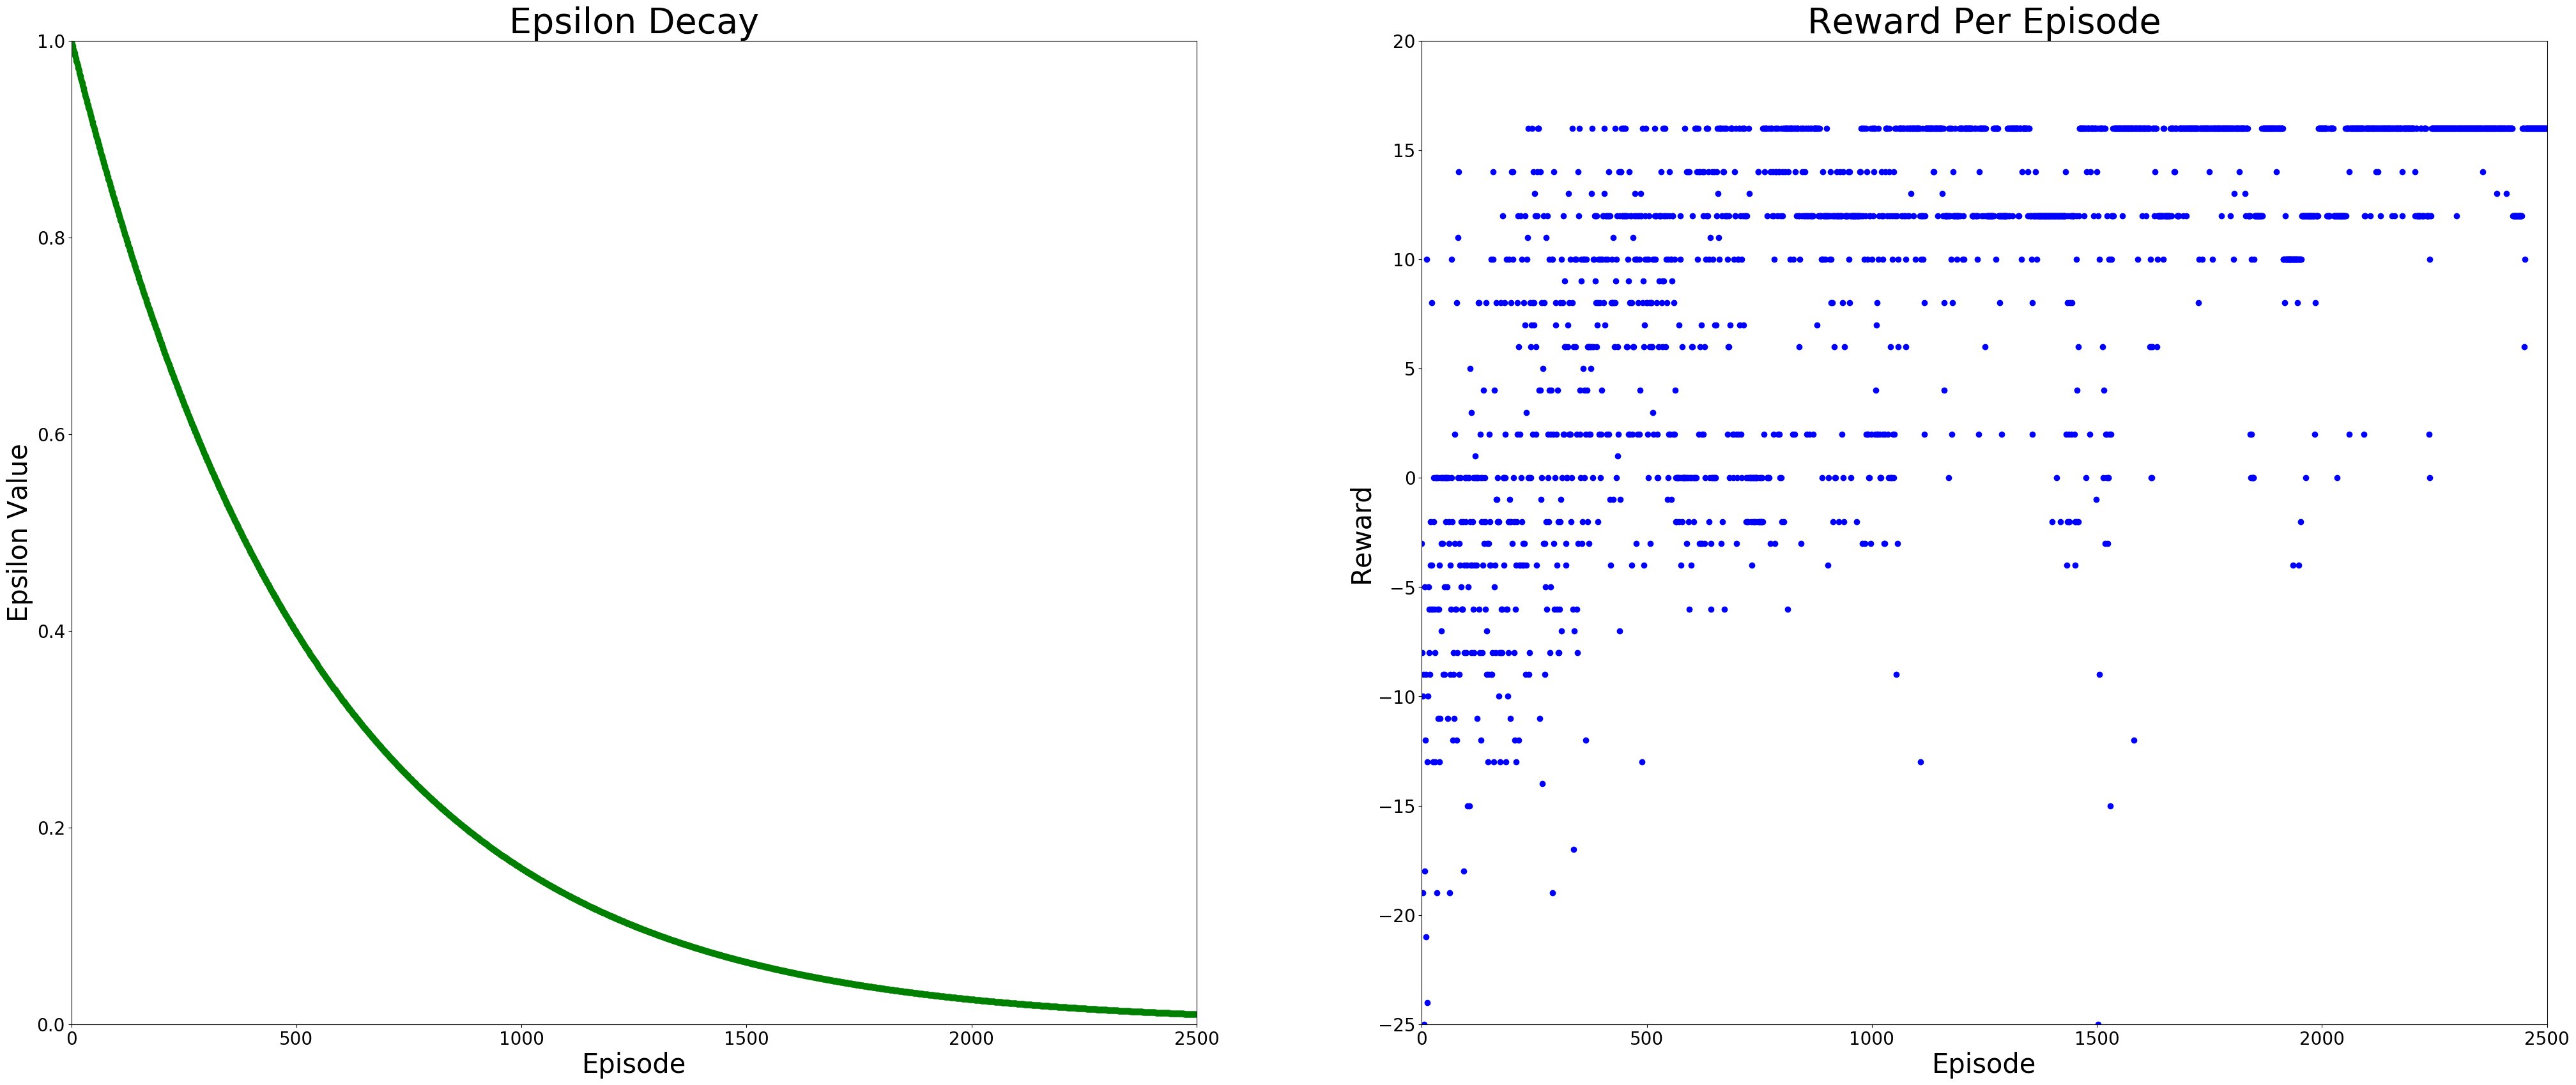

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

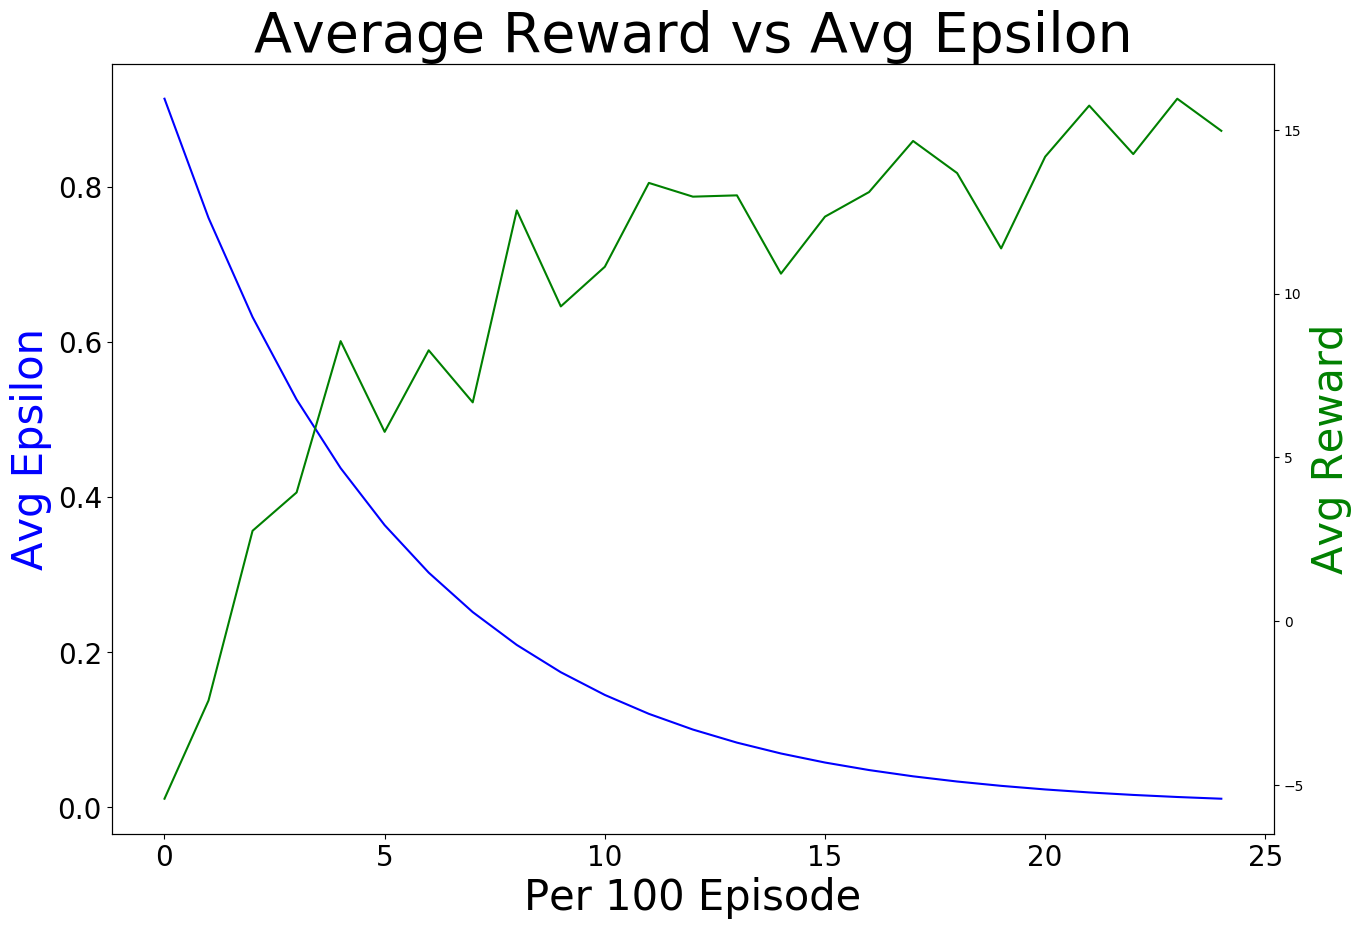

In [10]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [15]:
import json
with open('reward_dqn.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

In [17]:
import json
with open('reward_dqn.json') as f:
    reward_list_train_dqn = json.load(f)

In [11]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

In [20]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
a = GridVanillaDQN(env)
a.eval(load=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 10/10 [00:00<00:00, 122.96episodes/s]


In [21]:
reward_list_test_dqn = a.test_rewards_list

<Figure size 640x480 with 0 Axes>

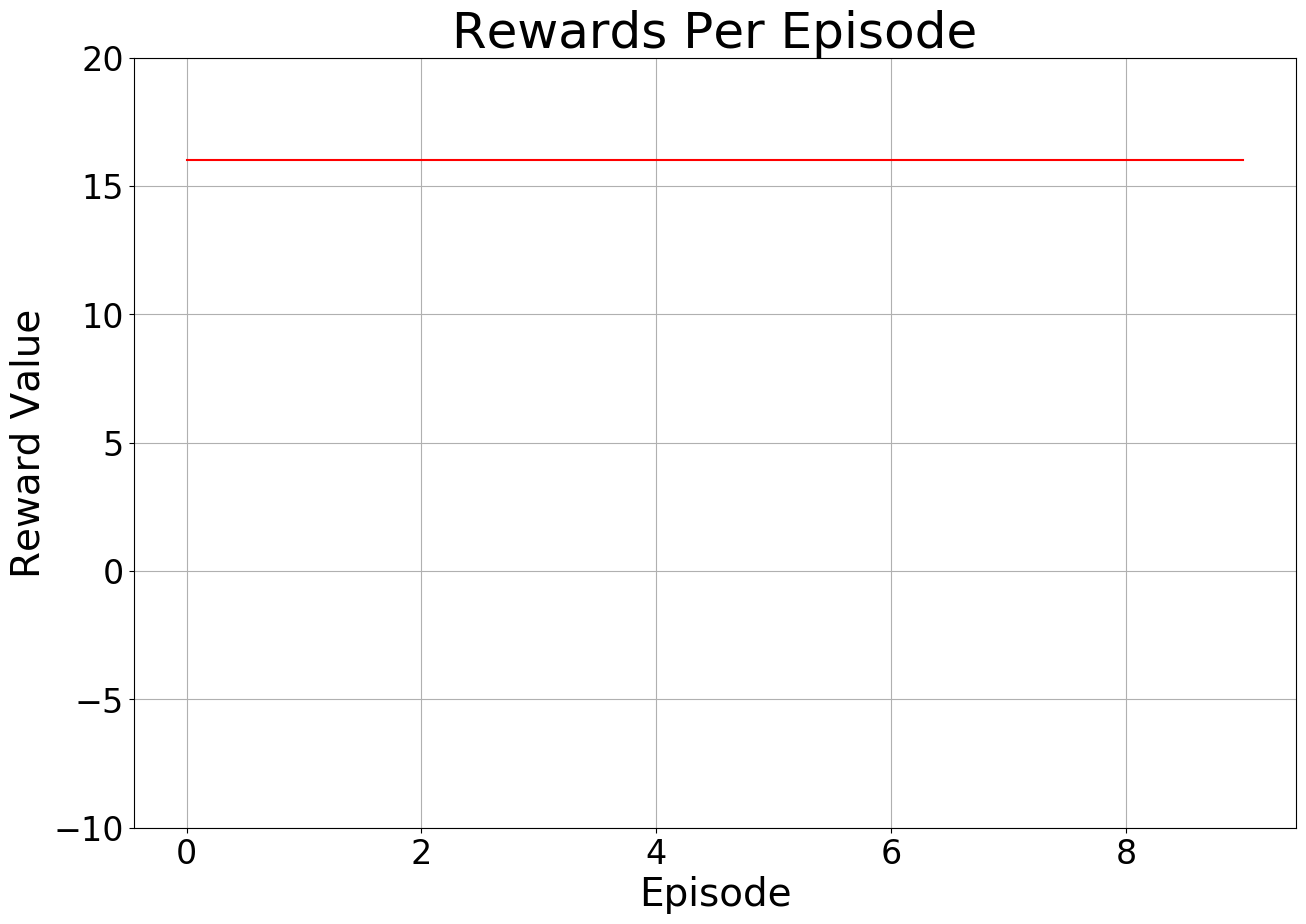

In [22]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()